In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf

from tensorflow.keras import optimizers, models, applications, metrics
from tensorflow.keras.layers import Dense, Input, Flatten, Softmax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard

In [3]:
from google.colab import drive
from google.colab import files 


drive.mount("/content/gdrive")
print(os.getcwd())
os.chdir("/content/gdrive/My Drive/AML2021/AML2021")
print(os.getcwd())

Mounted at /content/gdrive
/content
/content/gdrive/.shortcut-targets-by-id/1_nr6od538RmnZRE1gB6vQYFsrHaUgS19/AML2021/AML2021


In [4]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

print(x_train.shape, y_train.shape)

(16324, 299, 299, 3) (16324, 2)


In [5]:
# Adapt Constants
MODEL_NAME = f"VGG_No_Pretraining"
os.makedirs(f'models/{MODEL_NAME}', exist_ok = True) 
INPUT_SHAPE = (299, 299, 3)
NUM_CLASSES = 2
INITIAL_EPOCH = 0
NUM_EPOCHS = 120
OPTIMIZER = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
BATCH_SIZE = 16

LRS = ReduceLROnPlateau(monitor='val_auroc', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001)
ES = EarlyStopping(monitor='val_auroc', min_delta=0.0001, patience=8, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

MC_BEST = ModelCheckpoint(f'models/{MODEL_NAME}/best-{MODEL_NAME}.hdf5', monitor='val_auroc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
LOG = CSVLogger(f'models/{MODEL_NAME}/{MODEL_NAME}.log')
TB = TensorBoard(log_dir=f'models/{MODEL_NAME}/logs')

METRICS = [metrics.AUC(name='auroc', curve='ROC'),
           metrics.CategoricalAccuracy(name='accuracy'),
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
           ]

# Model: preprocess, base model, top layer/classifier
i = Input(shape=INPUT_SHAPE)
x = applications.vgg16.preprocess_input(i)

base_model = applications.VGG16(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
x = base_model(x)
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(NUM_CLASSES, name='predictions')(x)
o = Softmax()(x)


model = models.Model(inputs=i, outputs=o)

# Train Model
if INITIAL_EPOCH != 0:
	model = models.load_model(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', compile=True)
else:
  model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=METRICS)

model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split = 0.2, callbacks = [MC_BEST, LRS, ES, LOG, TB], epochs = NUM_EPOCHS, initial_epoch = INITIAL_EPOCH)



58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/120
  2/817 [..............................] - ETA: 16:50 - loss: 3874259730432.0000 - auroc: 0.5479 - accuracy: 0.5938 - precision: 0.5938 - recall: 0.5938

InvalidArgumentError: ignored

In [ ]:
# Eval Model
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

model = models.load_model(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', compile=True)
out = model.evaluate(x=x_test, y=y_test, batch_size=BATCH_SIZE, verbose=1)

# Save Results
with open("results.txt","a+") as f:
  f.write(f"{MODEL_NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n")
print(f"wrote \"{MODEL_NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n\" to results.txt ")

173/173 [==============================] - 17s 88ms/step - loss: 0.0817 - auroc: 0.9959 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696
wrote "Densenet121_NoPretraining_lowerPatience-14-09-2021_20-28-14 test_loss: 0.08173692971467972, test_auroc: 0.9958634972572327, test_acc: 0.9695982336997986, test_prec: 0.9695982336997986, test_rec: 0.9695982336997986, test_f1: 0.9695982336997986
" to results.txt 


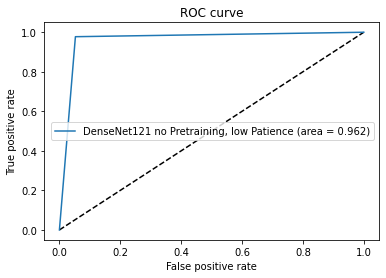

In [ ]:
#Plot ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='DenseNet121 no Pretraining, low Patience (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()